In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from matplotlib import pyplot as plt
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
!7z x /content/drive/MyDrive/myData/test.zip
!7z x /content/drive/MyDrive/myData/train.zip
!7z x /content/drive/MyDrive/myData/val.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/myData/                                        1 file, 362255881 bytes (346 MiB)

Extracting archive: /content/drive/MyDrive/myData/test.zip
  9% 4096 Open              --
Path = /content/drive/MyDrive/myData/test.zip
Type = zip
Physical Size = 362255881

  0%      1% 604 - test/live/015835.jpg                                 2% 1014 - test/live/027490.jpg                                  2% 1375 - test/live/037957.jpg                                

In [ ]:
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

In [ ]:
test_dir = '/content/test'

In [ ]:
epochs = 40
batch_size = 32
unfreeze_layers = 10

In [ ]:
def get_data_generators(train_dir, val_dir, test_dir, batch_size, target_size=(128, 128)):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = None
    val_generator = None
    test_generator = None


    if train_dir is not None:
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='binary'
        )


    if val_dir is not None:
        val_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='binary'
        )

    
    if test_dir is not None:
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False
        )

    return train_generator, val_generator, test_generator


In [ ]:
def create_mobilenet_model(input_size=(128, 128, 3)):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_size)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  
    predictions = Dense(1, activation='sigmoid')(x)  

    
    model = Model(inputs=base_model.input, outputs=predictions)

    
    if unfreeze_layers > 0:
        for layer in base_model.layers[:-unfreeze_layers]:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False

    return model


mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32)        128 

In [ ]:
train_generator, val_generator, _ = get_data_generators(train_dir, val_dir, test_dir=None,batch_size=batch_size)

mobilenet_model = create_mobilenet_model()
mobilenet_model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Found 196000 images belonging to 2 classes.
Found 42000 images belonging to 2 classes.


Epoch 1/40
6125/6125 [==============================] - 861s 140ms/step - loss: 0.2457 - accuracy: 0.9184 - val_loss: 0.1481 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 2/40
6125/6125 [==============================] - 857s 140ms/step - loss: 0.1635 - accuracy: 0.9394 - val_loss: 0.2105 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 3/40
6125/6125 [==============================] - 849s 139ms/step - loss: 0.1469 - accuracy: 0.9456 - val_loss: 0.2751 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 4/40
6125/6125 [==============================] - 856s 140ms/step - loss: 0.1357 - accuracy: 0.9501 - val_loss: 0.5665 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 5/40
6125/6125 [==============================] - 848s 138ms/step - loss: 0.1291 - accuracy: 0.9527 - val_loss: 0.0910 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 6/40
6125/6125 [==============================] - 833s 136ms/step - loss: 0.1229 - accuracy: 0.9554 - val_loss: 0.1090 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 7/40
6125/6125 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


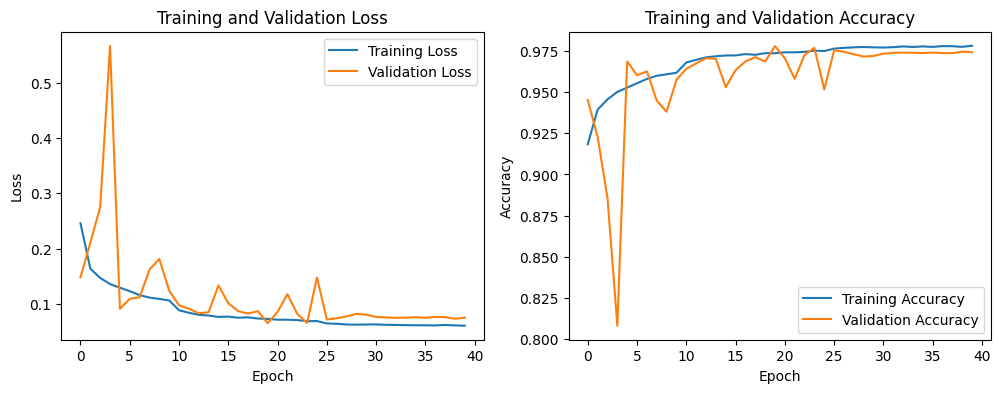

In [ ]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)


history = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[reduce_lr]  
)


mobilenet_model.save('mobilenet_model2.h5')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# TEST

In [ ]:
_, _, test_generator = get_data_generators(train_dir=None, val_dir=None, test_dir=r'/content/test',batch_size = batch_size)
model = tf.keras.models.load_model(r'/content/mobilenet_model2.h5')
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 42000 images belonging to 2 classes.
1313/1313 [==============================] - 33s 23ms/step - loss: 0.0717 - accuracy: 0.9748
Test Loss: 0.07169587165117264
Test Accuracy: 0.9748333096504211


In [ ]:
_, _, test_generator = get_data_generators(train_dir=None, val_dir=None, test_dir=r'/content/test',batch_size = batch_size)
model = tf.keras.models.load_model(r'/content/mobilenet_model2.h5')
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 42000 images belonging to 2 classes.
1313/1313 [==============================] - 37s 25ms/step - loss: 0.0717 - accuracy: 0.9748
Test Loss: 0.07169590145349503
Test Accuracy: 0.9748333096504211


1313/1313 [==============================] - 35s 26ms/step


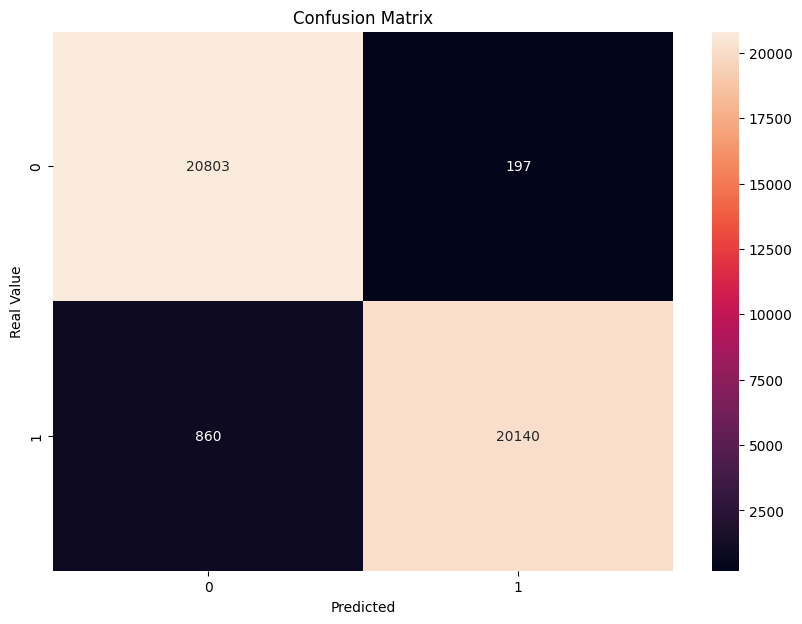

              precision    recall  f1-score   support

        live       0.96      0.99      0.98     21000
       spoof       0.99      0.96      0.97     21000

    accuracy                           0.97     42000
   macro avg       0.98      0.97      0.97     42000
weighted avg       0.98      0.97      0.97     42000



In [ ]:

y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)  


y_true = test_generator.classes


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Real Value')
plt.title('Confusion Matrix')
plt.show()


report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)